In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle # para salvar el modelo

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt # para dibujar 

In [5]:
from sklearn.feature_extraction import DictVectorizer # para one hot ecoding
from sklearn.linear_model import LinearRegression # para el modelo
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error #para evaluar el modelo

In [6]:
df = pd.read_parquet('./data/homework/fhv_tripdata_2021-01.parquet')
df.tail(20)
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [7]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) #duracion en minutos
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667


In [8]:
df.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [9]:
shp = df.shape
shp

(1154112, 8)

In [10]:
df.isnull()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,False,False,False,True,True,True,False,False
1,False,False,False,True,True,True,False,False
2,False,False,False,True,True,True,False,False
3,False,False,False,True,False,True,False,False
4,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1154107,False,False,False,False,False,True,False,False
1154108,False,False,False,False,False,True,False,False
1154109,False,False,False,False,False,True,False,False
1154110,False,False,False,False,False,True,False,False


In [11]:
NAN_count = df.isnull().sum()
NAN_count

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               958267
DOlocationID               162220
SR_Flag                   1154112
Affiliated_base_number        885
duration                        0
dtype: int64

In [12]:
nonNAN_count = df.count()
nonNAN_count

dispatching_base_num      1154112
pickup_datetime           1154112
dropOff_datetime          1154112
PUlocationID               195845
DOlocationID               991892
SR_Flag                         0
Affiliated_base_number    1153227
duration                  1154112
dtype: int64

In [13]:
len(df)*shp[1]

9232896

In [14]:
percent_missing = NAN_count/(NAN_count+ nonNAN_count)
percent_missing.round(4)*100

dispatching_base_num        0.00
pickup_datetime             0.00
dropOff_datetime            0.00
PUlocationID               83.03
DOlocationID               14.06
SR_Flag                   100.00
Affiliated_base_number      0.08
duration                    0.00
dtype: float64

In [15]:
percent_missing.mean()

0.24645398366882937

In [16]:
percent_missing = df.isnull().sum().sum()* 100 / (len(df)*shp[1])
percent_missing

24.645398366882937

In [17]:
df.isna().mean().round(4) * 100

dispatching_base_num        0.00
pickup_datetime             0.00
dropOff_datetime            0.00
PUlocationID               83.03
DOlocationID               14.06
SR_Flag                   100.00
Affiliated_base_number      0.08
duration                    0.00
dtype: float64

In [18]:
df = df[(df.duration >= 1) & (df.duration <= 60)] # se filtra luego de revisar la distribucion y percentiles ver el video
#df["DOlocationID"].unique()
#df["DOlocationID"].value_counts(dropna = False)
#df.fillna(0)
#df["DOlocationID"].fillna(0, inplace = True)
#df

In [19]:
#df["PUlocationID"].value_counts(dropna = False)
#df["PUlocationID"].fillna(0, inplace = True)
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


In [20]:
df.duration.describe()
df.shape

(1109826, 8)

In [21]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000


In [22]:
categorical = ['PUlocationID', 'DOlocationID', 'dispatching_base_num','Affiliated_base_number' ] # variables categoricas
#categorical = ['PUlocationID', 'DOlocationID'] # variables categoricas
#numerical = ['trip_distance'] #distancia del viaje 
# se podrian conseguir variables categoricas como dia de la semana, si es hora pico o no, etc

df[categorical] = df[categorical].astype(str) # transformamos en str las categoricas
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [23]:
train_dicts = df[categorical].to_dict(orient='records') # creamos los diccionario que usaremos con DictVectorizer

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

X_train.shape

(1109826, 1757)

In [24]:

target = 'duration'
y_train = df[target].values #target variable

lr = LinearRegression() #linear regreson model
lr.fit(X_train, y_train) 

y_pred = lr.predict(X_train) 

mean_squared_error(y_train, y_pred, squared=False) # los minutos que se falla en promedio en la prediccion

9.680116956956645

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


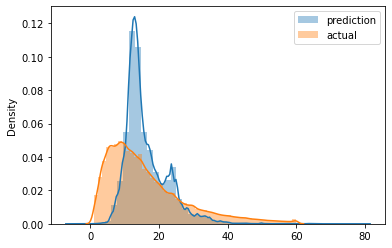

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend() # se ven muy diferentes.... el modelo parece no ser el mejor, lo usaremos como linea base

In [26]:
def read_dataframe(filename): #funcion para cargar los datos ...
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    
    #df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    #categorical = ['PUlocationID', 'DOlocationID']
    categorical = ['PUlocationID', 'DOlocationID', 'dispatching_base_num','Affiliated_base_number' ]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe('./data/homework/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/homework/fhv_tripdata_2021-02.parquet')

In [28]:
len(df_train), len(df_val)

(1109826, 990113)

In [29]:
df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']# convinacion del lugar de origen y destino
df_train['disp_aff'] = df_train['dispatching_base_num'] + '_' + df_train['Affiliated_base_number']
df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']
df_val['disp_aff'] = df_val['dispatching_base_num'] + '_' + df_val['Affiliated_base_number']

In [30]:
categorical = ['PU_DO', 'disp_aff'] #'PULocationID', 'DOLocationID'
#numerical = ['trip_distance']

dv2 = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv2.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv2.transform(val_dicts)

In [31]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train)

y_pred = lr2.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.953689071075644

In [33]:
with open('models/lin_reg_2.bin', 'wb') as f_out2:
    pickle.dump((dv2, lr2), f_out2) # salvamos el modelo 

In [34]:
lr2_1 = Lasso(0.01)
lr2_1.fit(X_train, y_train)

y_pred = lr2_1.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.009248865080608

Lasso 0.01 : 11.0092

In [35]:
with open('models/lin_reg_2_1.bin', 'wb') as f_out2_1:
    pickle.dump((dv2, lr2_1), f_out2_1) # salvamos el modelo 